In [264]:
import numpy as np
import pandas as pd
#import scipy
from scipy.special import binom
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
# from scipy.stats import quantile
# from itertools import combinations

# Load source_ACR module
# Assuming the relevant functions are defined in source_ACR.py
import source_ACR_py as acr

In [233]:
# Initialization
eps_acr = 0.01
thres_positive = 0.01
num_S = 3
max_order = 2
num_R = 3
source_mat = None
product_mat = None
stoi_mat = None

In [355]:
def MAK(t, x, kappa, source_mat, stoi_mat):
    f = np.zeros(len(kappa1))
    for i in range(len(kappa1)):
        f[i] = np.prod(np.power(x, source_mat[:,i]))
    r = kappa * f
    dx_vec = np.matmul(stoi_mat, r)
    return dx_vec

def MAK_rsc(t, x, kappa, source_mat, stoi_mat):
    f = np.zeros(len(kappa1))
    for i in range(len(kappa1)):
        f[i] = np.prod(np.power(x, source_mat[:,i]))
    r = kappa * f
    dx_vec = np.matmul(stoi_mat, r)
    dx_vec_rsc = dx_vec / (1 + np.sqrt(np.sum(dx_vec**2)))
    return dx_vec_rsc


num_total_C = int(scipy.special.binom(max_order + num_S, num_S))
# num_total_C = binomial(max_order + num_S, num_S)
total_complex = acr.make_total_complexes(num_S, max_order).astype(int)

num_total_R = num_total_C * (num_total_C - 1)
num_total_net = int(scipy.special.binom(num_total_R, num_R))

num_repeat_net = num_total_net
num_repeat_par = 5
num_repeat_init = 20
matrix_R_id = np.zeros((num_R, num_repeat_net), dtype=int)
list_acr_id = np.zeros((num_S, num_repeat_net), dtype=int)
list_unbnd_id = np.zeros((num_S, num_repeat_net), dtype=int)

(3,)
(3,)
[5.89112267 4.19076832 8.96571989]
[[1 0 1]
 [0 2 0]
 [0 0 1]]
[-7.26536553  8.38153663  8.96571989]
[-0.47602622  0.54915767  0.58743331]
['0 -> A', 'A -> 2B', '2A -> A+C']
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50.]


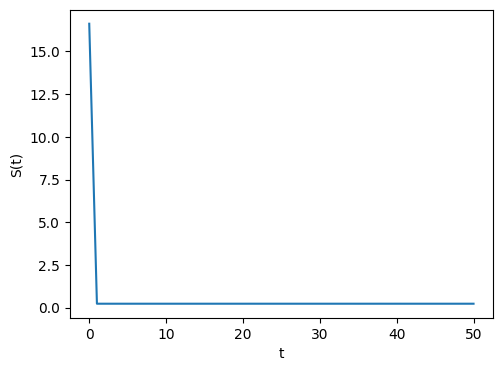

In [383]:
#acr.make_total_complexes(num_S, max_order)
# sss=acr.make_total_complexes(num_S, max_order).astype(int)
#matrix_R_id
#list_acr_id
#list_unbnd_id
#total_complex
#print(source_mat)
ff = np.power(source_mat[:,2], source_mat[:,2])
#print(ff)
#print(ff*ff)
print(np.zeros(3).shape)
print(kappa1.shape)
rr = kappa1 * ff
print(rr)
print(product_mat)
print(np.matmul(stoi_mat, rr))
dx_vec=np.matmul(stoi_mat, rr)
dx_vec = dx_vec / (1 + np.sqrt(np.sum(dx_vec**2)))
print(dx_vec)
print(acr.crn_writing(source_mat, product_mat)[1])
#print(acr.crn_writing(source_mat, product_mat))
#acr.crn_embedding(source_mat, product_mat)
#sol1.y.T.shape
#sol1.t

sol1 = solve_ivp(MAK, tspan1, x_init, args = (kappa1, source_mat, stoi_mat), method='RK45', t_eval=t_eval)
plt.figure(figsize = (12, 4))
plt.subplot(121)
print(sol1.t)
plt.plot(sol1.t, sol1.y[0])
plt.xlabel('t')
plt.ylabel('S(t)')
plt.show()

# (kappa1, source_mat, stoi_mat)
#sol1.t

In [377]:
# Beginning of the random network search
rnd_search = False
for iter_network in range(1000, 1002):
    if iter_network % 10 == 1:
        print(f"======= Analyzing network {iter_network:4} =======")

    if rnd_search:
        list_R_id = np.random.choice(range(1, num_total_R + 1), num_R, replace=False)
    else:
        list_R_id = acr.net_id_to_r_id_list(iter_network, num_total_R, num_R)

    list_source_id, list_product_id = zip(*[acr.reaction_to_complex(r_id, num_total_C) for r_id in list_R_id])
    source_mat = total_complex[:, np.array(list_source_id)-1]
    product_mat = total_complex[:, np.array(list_product_id)-1]
    stoi_mat = product_mat - source_mat

    # Simulation settings
    #kappa1 = np.random.uniform(low=0.0, high=10.0, size=num_R)
    #x_init = np.random.uniform(low=1.0, high=20.0, size=num_S)
    tspan1 = (0.0, 50.0)

    ub_param = 10 * np.ones(num_R)
    lb_param = np.zeros(num_R)

    ub_init = 20 * np.ones(num_S)
    lb_init = np.ones(num_S)

    list_acr_id_par = np.zeros((num_S, num_repeat_par), dtype=int)
    list_unbnd_id_par = np.zeros((num_S, num_repeat_par), dtype=int)

    for iter_par in range(1, num_repeat_par + 1):
        kappa1 = np.random.uniform(low=lb_param, high=ub_param, size=num_R)
        final_val_mat = np.zeros((num_S, num_repeat_init))
        latter_val_mat = np.zeros((num_S, num_repeat_init))

        for iter_init in range(1, num_repeat_init + 1):
            x_init = np.random.uniform(low=lb_init, high=ub_init, size=num_S)
            t_eval = np.arange(tspan1[0], tspan1[1]+1, 1)
            sol1 = solve_ivp(MAK_rsc, tspan1, x_init, args = (kappa1, source_mat, stoi_mat), method='RK45', t_eval=t_eval)
            sol_mat1 = sol1.y.T
            length_tspan = sol_mat1.shape[0]
            final_val_mat[:, iter_init - 1] = sol_mat1[length_tspan - 1, :]

            if int(np.floor(0.8 * length_tspan)) >= 1:
                latter_val_mat[:, iter_init - 1] = sol_mat1[int(np.floor(0.8 * length_tspan)), :]

        upp_val = np.array([np.quantile(final_val_mat[i, :], 0.6) for i in range(num_S)])
        low_val = np.array([np.quantile(final_val_mat[i, :], 0.4) for i in range(num_S)])

        for i in range(num_S):
            if upp_val[i] - low_val[i] < eps_acr and low_val[i] > thres_positive:
                list_acr_id_par[i, iter_par - 1] = 1
            if np.mean(latter_val_mat[i, :]) > ub_init[i] and np.mean(final_val_mat[i, :]) > np.mean(latter_val_mat[i, :]) + 2:
                list_unbnd_id_par[i, iter_par - 1] = 1

    for i in range(num_S):
        if np.sum(list_acr_id_par[i, :]) > 0:
            list_acr_id[i, iter_network - 1] += 1
        if np.prod(list_acr_id_par[i, :]) > 0:
            list_acr_id[i, iter_network - 1] += 1
        if np.sum(list_unbnd_id_par[i, :]) > 0:
            list_unbnd_id[i, iter_network - 1] += 1
        if np.prod(list_unbnd_id_par[i, :]) > 0:
            list_unbnd_id[i, iter_network - 1] += 1

    matrix_R_id[:, iter_network - 1] = list_R_id

======= Analyzing network 1001 =======


In [182]:
# Convert arrays to pandas DataFrames and save to CSV files
list_acr_id_df = pd.DataFrame(list_acr_id)
list_unbnd_id_df = pd.DataFrame(list_unbnd_id)
matrix_R_id_df = pd.DataFrame(matrix_R_id)

path = "/Users/hyukpyohong/Dropbox/CRN_dynamicACR/Codes/data/"
list_acr_id_df.to_csv(path + f"python_list_acr_id_S{num_S}R{num_R}_max_ord{max_order}.csv", header=False, index=False)
list_unbnd_id_df.to_csv(path + f"python_list_unbnd_id_S{num_S}R{num_R}_max_ord{max_order}.csv", header=False, index=False)
matrix_R_id_df.to_csv(path + f"python_matrix_R_id_S{num_S}R{num_R}_max_ord{max_order}.csv", header=False, index=False)